https://github.com/gretelai/gretel-synthetics/blob/master/examples/timeseries_dgan.ipynb

In [1]:
# version recommended by source
!pip install torch==1.11.0

     |██████████████▋                 | 342.2 MB 155.0 MB/s eta 0:00:03

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 750.6 MB 172.1 MB/s            
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
!pip install git+https://github.com/gretelai/gretel-synthetics.git

  Cloning https://github.com/gretelai/gretel-synthetics.git to /tmp/pip-req-build-wyr_o9dd
  Running command git clone --filter=blob:none -q https://github.com/gretelai/gretel-synthetics.git /tmp/pip-req-build-wyr_o9dd
  Resolved https://github.com/gretelai/gretel-synthetics.git to commit 2ed9d31ce8f56afd1519c38859ab081e8cdef579
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 67 kB 31.7 MB/s            
     |████████████████████████████████| 1.2 MB 118.4 MB/s            
     |████████████████████████████████| 58 kB 114.6 MB/s            
     |████████████████████████████████| 251 kB 134.4 MB/s            
     |████████████████████████████████| 6.3 MB 111.0 MB/s            
     |████████████████████████████████| 438 kB 117.3 MB/s            
     |████████████████████████████████| 142 kB 137.9 MB/s            
     |████████████████████████████████| 532 kB 119.2 MB/s            
     |████████████████████████████████| 4.3 MB 113.2 MB/s            
 

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from pickle import dump, load

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

In [4]:
# https://www.kaggle.com/code/xiaxiaxu/predictmachinefailureinadvance/data
sensor = pd.read_csv("sensor.csv")
sensor.isnull().sum()
COLS_TO_DROP = ["Unnamed: 0", "sensor_00", "sensor_15", "sensor_50", "sensor_51"]
sensor.drop(COLS_TO_DROP, axis=1, inplace=True)

print(sensor.shape)

(220320, 50)


In [5]:
# lets convert our datatypes to the correct ones
print(sensor.dtypes, "\n")
# i have no idea why i have to run this line twice for it to work.
sensor["timestamp"] = pd.to_datetime(sensor["timestamp"])

timestamp          object
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35         float64
sensor_36         float64
sensor_37         float64
sensor_38         float64
sensor_39   

In [6]:
# how many NaN rows do we have?
print(len(sensor[sensor.isna().any(axis=1)]))

6849


In [7]:
# lets drop them
sensor.dropna(axis=0, inplace=True)
print(len(sensor[sensor.isna().any(axis=1)]))

0


In [8]:
# lets try only using data centered around 2 failures.
data_around_failures = sensor.iloc[16000:26080]
print(len(data_around_failures))
data_around_failures

10080


,timestamp,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status
16030,2018-04-12 03:10:00,50.954860,52.039930,45.138885,637.500000,69.71821,13.563370,16.167530,15.697340,15.118630,...,32.552080,35.156250,51.04166,39.641200,40.219910,37.905094,38.194440,135.99540,54.108800,NORMAL
16031,2018-04-12 03:11:00,50.954860,51.953120,45.138890,634.722200,69.88378,13.628470,16.203700,15.769680,15.162040,...,32.552080,34.895830,51.04166,39.351850,39.641200,37.905094,37.905090,137.15280,53.819440,NORMAL
16032,2018-04-12 03:12:00,50.954860,52.039930,45.182290,623.495400,70.89301,13.614000,16.210940,15.653930,15.082470,...,32.291660,34.895832,50.78125,39.062500,39.351850,37.905094,37.615740,142.93980,53.819440,NORMAL
16033,2018-04-12 03:13:00,50.954860,52.039928,45.182289,645.138900,69.25391,13.527200,16.073500,15.653930,15.082470,...,32.291660,34.895832,50.00000,38.773150,39.351850,37.905094,37.615740,148.14810,53.530090,NORMAL
16034,2018-04-12 03:14:00,50.954860,52.039930,45.182289,641.898200,69.87685,13.498260,16.131360,15.769680,15.010130,...,32.552080,34.895830,49.47916,38.773150,39.062500,37.905090,37.326390,149.59490,53.240740,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26877,2018-04-19 15:57:00,39.973957,38.715270,36.545139,204.071167,0.00000,0.028935,0.036169,0.028935,0.007234,...,38.281250,39.583332,46.87500,36.747684,36.747684,42.534721,41.087963,36.16898,35.879631,RECOVERING
26878,2018-04-19 15:58:00,39.973957,38.671880,36.545140,202.219315,0.00000,0.028935,0.036169,0.028935,0.007234,...,38.802080,39.583330,46.87500,36.747684,36.747684,42.534721,41.087963,36.16898,35.879631,RECOVERING
26879,2018-04-19 15:59:00,39.973960,38.671875,36.501740,203.145233,0.00000,0.028935,0.036169,0.028935,0.007234,...,38.802082,40.104160,46.87500,36.747684,36.747684,42.534721,41.087963,36.16898,35.879630,RECOVERING
26880,2018-04-19 16:00:00,40.017361,38.671875,36.501736,205.344315,0.00000,0.028935,0.036169,0.028935,0.007234,...,38.802082,40.104164,46.87500,36.747684,36.747684,42.534721,41.087963,36.16898,35.879631,RECOVERING


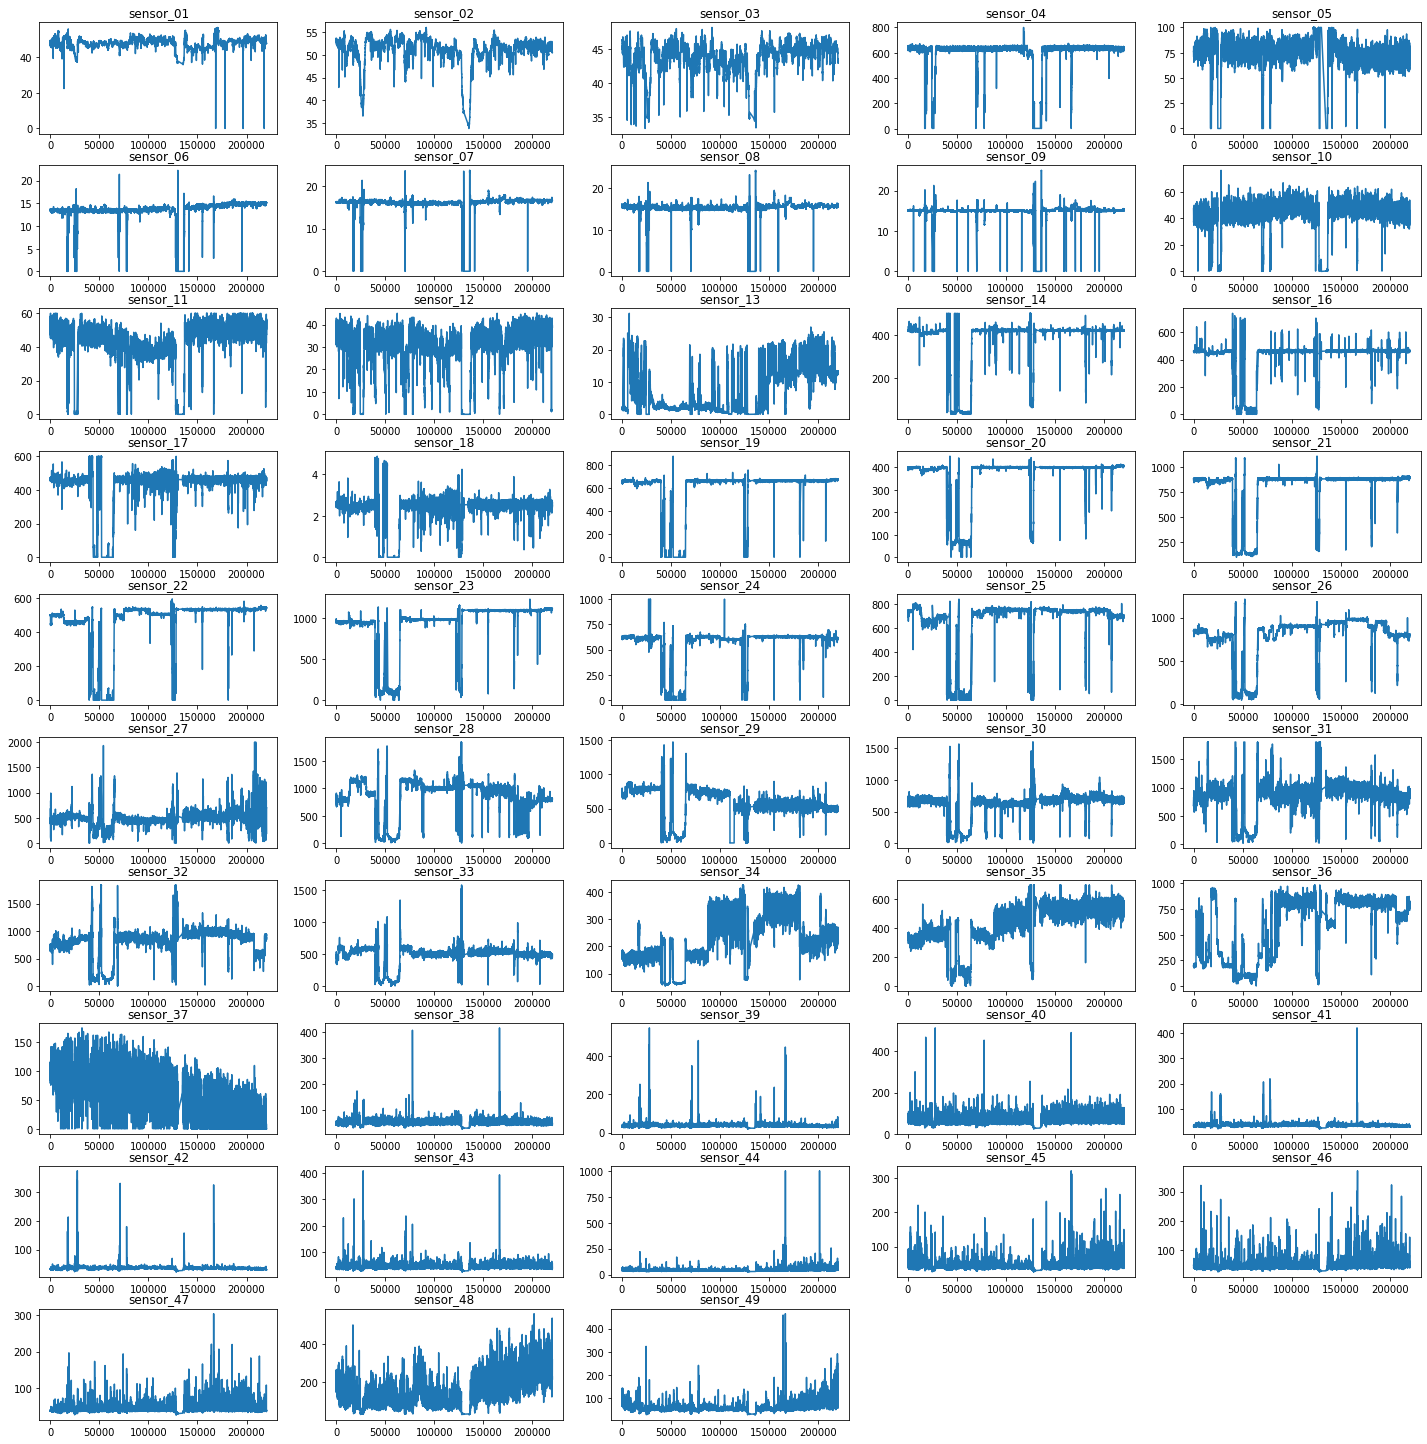

In [9]:
# subplot matrix
fig, axes = plt.subplots(10, 5, figsize=(20, 20))
fig.tight_layout()

for col, ax in zip(sensor.columns[1:-1], axes.flat):
    sensor[col].plot.line(ax=ax)
    ax.set_title(col)
# disable leftover axes
for ax in axes.flat[sensor.columns[1:-1].size :]:
    ax.set_axis_off()

okay, scaling sanity check passed. lets start splitting the data to prepare it for training in dGAN.

NOTE: data generated will be in the shape of data passed in for training. so if we pass in samples of 10 rows per, it will only generate a sample of 10 rows.

we have 10,080 rows of data now, which corresponds to 10,080 minutes of data = 168 hours of data = 7 days of data.

I'm going to try splitting the data into two hour segments - giving us 84 120row/minute readings.

In [12]:
# dropping timestamp and machine_status columns
data_around_failures.drop(["timestamp", "machine_status"], axis=1, inplace=True)
features = data_around_failures.to_numpy()
print(features.shape)

# number of samples to split into
n = features.shape[0] // 120
print(n)

# reshape the data accordingly
features = features[: (n * 120), :].reshape(-1, 120, features.shape[1])
# Shape is now (# examples, # time points, # features)
print(features.shape)

(10080, 48)
84
(84, 120, 48)


/opt/app-root/lib64/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [13]:
# Recommended to train with a GPU - am not for now.
torch.cuda.is_available()

False

In [14]:
# set up DGAN config.
config = DGANConfig(
    max_sequence_len=features.shape[1],
    sample_len=12,
    batch_size=min(1000, features.shape[0]),
    apply_feature_scaling=True,  # already scaled
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000,
)

model = DGAN(config)

In [15]:
model.train_numpy(
    features,
    feature_types=[OutputType.CONTINUOUS] * features.shape[2],
)

2022-08-05 15:32:10,055 : MainThread : INFO : epoch: 0
/opt/app-root/lib64/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
2022-08-05 15:32:10,740 : MainThread : INFO : epoch: 1
2022-08-05 15:32:11,100 : MainThread : INFO : epoch: 2
2022-08-05 15:32:11,409 : MainThread : INFO : epoch: 3
2022-08-05 15:32:11,719 : MainThread : INFO : epoch: 4
2022-08-05 15:32:12,031 : MainThread : INFO : epoch: 5
2022-08-05 15:32:12,345 : MainThread : INFO : epoch: 6
2022-08-05 15:32:12,656 : MainThread : INFO : epoch: 7
2022-08-05 15:32:12,959 : MainThread : INFO : epoch: 8
2022-08-05 15:32:13,258 : MainThread : INFO : epoch: 9
2022-08-05 15:32:13,559 : MainThread : INFO : epoch: 10
2022-08-05 15:32:13,856 : MainThread : INFO : epoch: 11
2022-08-05 15:32:14,158 : MainThread : INFO : epoch: 12
2022-08-05 15:32:14,456 : Ma

finished training at around 6-7 mins on large notebook image - not bad! 

In [16]:
# Generate synthetic data - this ran near instantly
_, synthetic_features = model.generate_numpy(100)

In [29]:
# Weak correlations between synthetic and real data
sensor_cols = data_around_failures.columns
synthetic_df = pd.DataFrame(
    synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=sensor_cols
)
data_around_failures.reset_index(inplace=True)
data_around_failures.corrwith(synthetic_df)

sensor_01    0.146386
sensor_02    0.147340
sensor_03    0.139688
sensor_04    0.116081
sensor_05    0.109915
sensor_06    0.136847
sensor_07    0.181678
sensor_08    0.233447
sensor_09    0.148166
sensor_10    0.106819
sensor_11    0.099187
sensor_12    0.121982
sensor_13    0.144833
sensor_14    0.182635
sensor_16    0.157878
sensor_17    0.067302
sensor_18    0.058091
sensor_19    0.262502
sensor_20    0.260023
sensor_21    0.261206
sensor_22   -0.033963
sensor_23   -0.005899
sensor_24    0.237180
sensor_25   -0.016326
sensor_26   -0.021768
sensor_27   -0.015896
sensor_28    0.143733
sensor_29    0.022816
sensor_30    0.058214
sensor_31   -0.005780
sensor_32    0.132098
sensor_33   -0.011429
sensor_34    0.110266
sensor_35    0.086664
sensor_36   -0.067314
sensor_37    0.006726
sensor_38   -0.060572
sensor_39   -0.057431
sensor_40   -0.015133
sensor_41   -0.005334
sensor_42   -0.025324
sensor_43   -0.015169
sensor_44    0.033413
sensor_45   -0.032609
sensor_46   -0.019988
sensor_47 

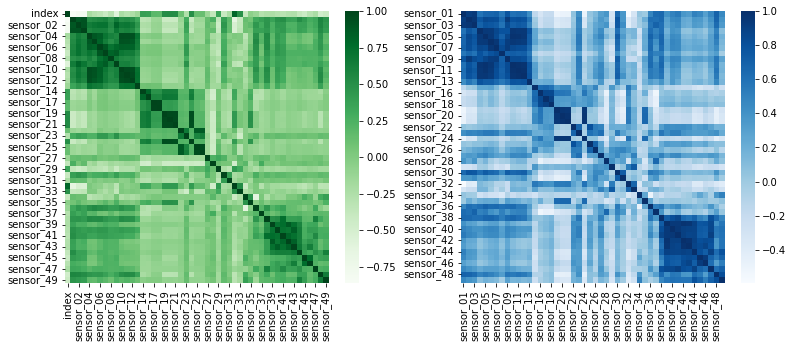

In [38]:
# Mutlicorrelation seems to be a problem in both the real and synthetic data;
# but at least this means that the synthetic data is mimicing the real data well.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(data_around_failures.corr(), cmap="Greens", ax=ax1)
sns.heatmap(synthetic_df.corr(), cmap="Blues", ax=ax2)
plt.show()

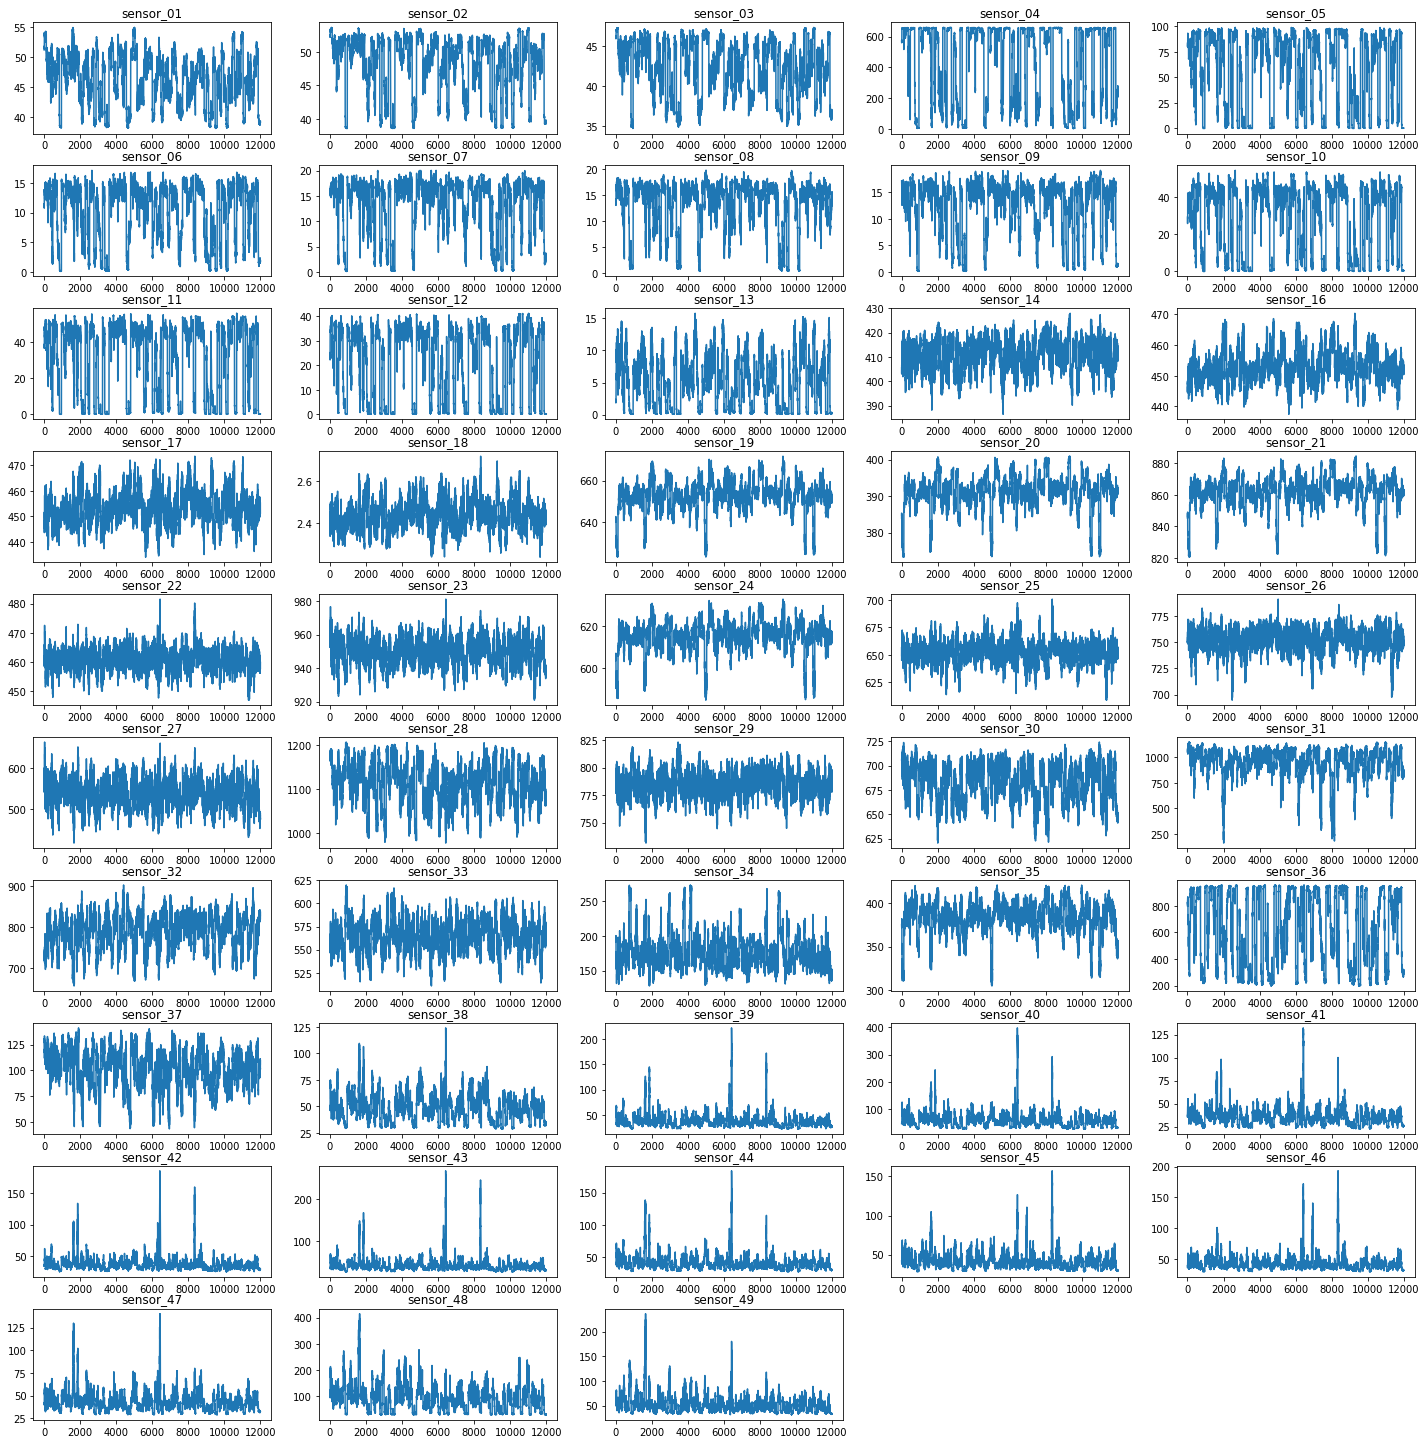

In [39]:
# Scatterplot matrix for synthetic sensor data

fig, axes = plt.subplots(10, 5, figsize=(20, 20))
fig.tight_layout()

for col, ax in zip(synthetic_df.columns, axes.flat):
    synthetic_df[col].plot.line(ax=ax)
    ax.set_title(col)
# disable leftover axes
for ax in axes.flat[synthetic_df.columns.size :]:
    ax.set_axis_off()

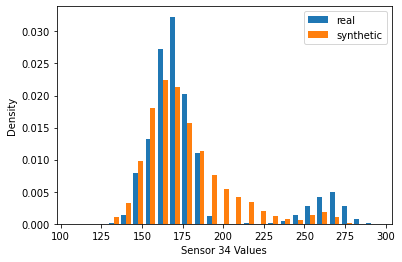

In [40]:
# Compare distribution of sensor_34 values

plt.hist(
    [data_around_failures["sensor_34"], synthetic_df["sensor_34"]],
    label=["real", "synthetic"],
    bins=25,
    density=True,
)
plt.legend()
plt.xlabel("Sensor 34 Values")
plt.ylabel("Density")
plt.show()

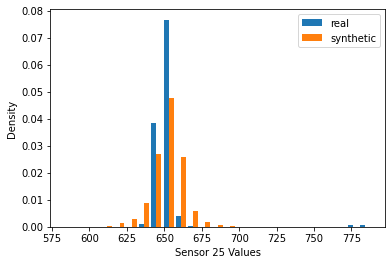

In [44]:
# Compare distribution of sensor_25 values

plt.hist(
    [data_around_failures["sensor_25"], synthetic_df["sensor_25"]],
    label=["real", "synthetic"],
    bins=25,
    density=True,
)
plt.legend()
plt.xlabel("Sensor 25 Values")
plt.ylabel("Density")
plt.show()

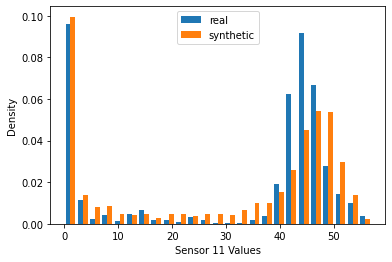

In [45]:
# Compare distribution of sensor_11 values

plt.hist(
    [data_around_failures["sensor_11"], synthetic_df["sensor_11"]],
    label=["real", "synthetic"],
    bins=25,
    density=True,
)
plt.legend()
plt.xlabel("Sensor 11 Values")
plt.ylabel("Density")
plt.show()

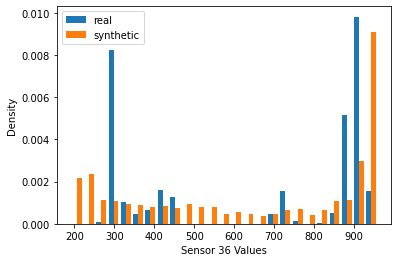

In [46]:
# Compare distribution of sensor_36 values

plt.hist(
    [data_around_failures["sensor_36"], synthetic_df["sensor_36"]],
    label=["real", "synthetic"],
    bins=25,
    density=True,
)
plt.legend()
plt.xlabel("Sensor 36 Values")
plt.ylabel("Density")
plt.show()

In [47]:
# saving model for future use
model.save("dgan_model_3_48_sensors.pt")

# X = model.load("dgan_model_3_48_sensors.pt")

# X